In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# GPU veya CPU seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cpu


In [40]:
# Özel Dataset Sınıfı
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]
        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = -1  # Test seti için etiket bulunmuyor
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]
        
        # Görüntü formatını dönüştür
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [41]:
# Veri augmentasyonu ve normalizasyon
transform = transforms.Compose([
    transforms.RandomRotation(20),  # Görüntüleri döndürme
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Perspektif bozulması
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Piksel değerlerini normalize et
])

In [42]:
# Eğitim ve test veri setleri
train_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/train.csv', transform=transform)
test_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/test.csv', transform=transform, is_test=True)

In [43]:
# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Veri Seti Boyutları -> Eğitim: {len(train_dataset)}, Test: {len(test_dataset)}")

Veri Seti Boyutları -> Eğitim: 42000, Test: 28000


In [44]:
# CNN Modeli
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [45]:
# Model, kayıp fonksiyonu ve optimizasyon
model = AdvancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# Eğitim Döngüsü
num_epochs = 20
training_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Ortalama Kayıp: {avg_loss:.4f}")

Epoch 1/20, Ortalama Kayıp: 0.2588
Epoch 2/20, Ortalama Kayıp: 0.1089
Epoch 3/20, Ortalama Kayıp: 0.0896
Epoch 4/20, Ortalama Kayıp: 0.0820
Epoch 5/20, Ortalama Kayıp: 0.0702
Epoch 6/20, Ortalama Kayıp: 0.0611
Epoch 7/20, Ortalama Kayıp: 0.0605
Epoch 8/20, Ortalama Kayıp: 0.0561
Epoch 9/20, Ortalama Kayıp: 0.0535
Epoch 10/20, Ortalama Kayıp: 0.0535
Epoch 11/20, Ortalama Kayıp: 0.0504
Epoch 12/20, Ortalama Kayıp: 0.0462
Epoch 13/20, Ortalama Kayıp: 0.0456
Epoch 14/20, Ortalama Kayıp: 0.0423
Epoch 15/20, Ortalama Kayıp: 0.0424
Epoch 16/20, Ortalama Kayıp: 0.0405
Epoch 17/20, Ortalama Kayıp: 0.0415
Epoch 18/20, Ortalama Kayıp: 0.0388
Epoch 19/20, Ortalama Kayıp: 0.0383
Epoch 20/20, Ortalama Kayıp: 0.0366


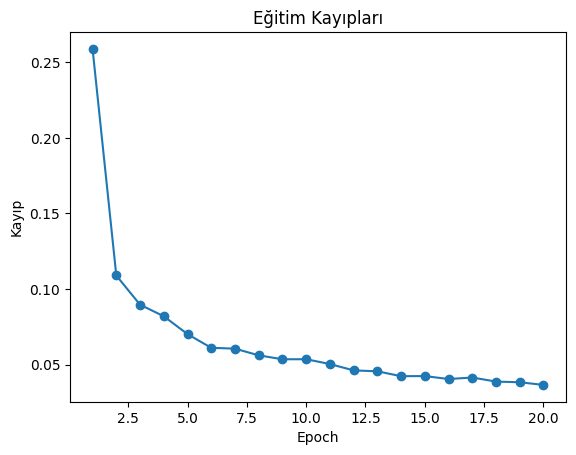

In [47]:
# Eğitim Kayıpları Grafiği
plt.plot(range(1, num_epochs + 1), training_losses, marker='o')
plt.title("Eğitim Kayıpları")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.show()

In [48]:
# Model Değerlendirme
model.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

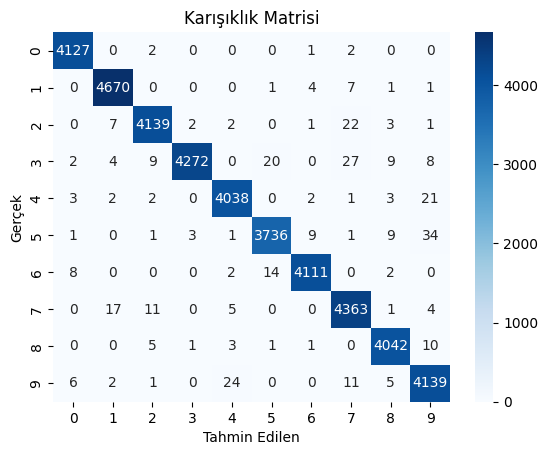

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       0.99      1.00      1.00      4684
           2       0.99      0.99      0.99      4177
           3       1.00      0.98      0.99      4351
           4       0.99      0.99      0.99      4072
           5       0.99      0.98      0.99      3795
           6       1.00      0.99      0.99      4137
           7       0.98      0.99      0.99      4401
           8       0.99      0.99      0.99      4063
           9       0.98      0.99      0.98      4188

    accuracy                           0.99     42000
   macro avg       0.99      0.99      0.99     42000
weighted avg       0.99      0.99      0.99     42000



In [49]:
# Karışıklık Matrisi ve Sınıflandırma Raporu
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

print("Sınıflandırma Raporu:")
print(classification_report(true_labels, pred_labels))

In [ ]:
test_predictions = []
model.eval()  # Modeli değerlendirme moduna al

with torch.no_grad():  # Gradient hesaplama devre dışı
    for images, _ in test_loader:  # Test loader'dan yalnızca görüntüler geliyor
        images = images.to(device)  # Görüntüleri cihaza aktar
        outputs = model(images)  # Modelden tahmin al
        _, predicted = torch.max(outputs, 1)  # En yüksek olasılığı seç
        test_predictions.extend(predicted.cpu().tolist())  # CPU'ya aktar ve listeye ekle

# Tahminleri bir DataFrame'e kaydet
submission = pd.DataFrame({
    "ImageId": range(1, len(test_predictions) + 1),
    "Label": test_predictions
})
submission.to_csv('sonuç.csv', index=False)
print("Sonuçlar sonuç.csv dosyasına kaydedildi.")
